In [0]:
# Losing customers (aka., churn) is an important business problem, because the cost of acquiring a new customer is often much higher than retaining an existing one. Being able to predict churn can help a company to prioritize retention program on customers who are most likely to churn, taking actions even before a churn happens.
# In this notebook we will just do an EDA to understand our Data & answer few critical questions which could help business to get insights

# Import libraries

In [0]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

#Spark Session

In [0]:
#set seaborn style
sns.set(style="whitegrid")

# spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

In [0]:
spark.conf.get("spark.executor.memory")

Out[4]: '8278m'

In [0]:
spark

Out[5]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.0 
 Master 
 local[8] 
 AppName 
 Databricks Shell

# Read data

In [0]:
# reading json data loaded in Databraicks database table manually
main_df = spark.table("mini_sparkify_event_data_json")

# Analysis of Dataset

In [0]:
# check first few rows of dataframe
main_df.take(2)

Out[7]: [Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

In [0]:
# check all columns of dataframe
main_df.columns

Out[8]: ['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [0]:
type(main_df)

Out[9]: pyspark.sql.dataframe.DataFrame

In [0]:
# check number of partitions
main_df.rdd.getNumPartitions()

Out[10]: 8

In [0]:
main_df = main_df.repartition(5) # difference between repartition & repartition by Range

In [0]:
main_df.rdd.getNumPartitions()

Out[12]: 5

In [0]:
main_df.collect()

Out[11]: [Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Time For Miracles', status=200, ts=1538352394000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Enigma', auth='Logged In', firstName='Micah', gender='M', itemInSession=80, lastName='Long', length=262.71302, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Knocking On Forbidden Doors', status=200, ts=1538352416000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Daft Punk', auth='Logged In', firstName='Colin', gender='M', itemInSession=52, lastName='Freeman', length=223.60771, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Harder Better Faster Stronger', status=200, ts=1538352676000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='The All-American Rejects', auth='Logged In', firstName='Micah', gender='M', itemInSession=81, lastName='Long', length=208.29995, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song="Don't Leave Me", status=200, ts=1538352678000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='The Velvet Underground / Nico', auth='Logged In', firstName='Micah', gender='M', itemInSession=82, lastName='Long', length=260.46649, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Run Run Run', status=200, ts=1538352886000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Starflyer 59', auth='Logged In', firstName='Colin', gender='M', itemInSession=53, lastName='Freeman', length=185.44281, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Passengers (Old Album Version)', status=200, ts=1538352899000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist=None, auth='Logged In', firstName='Colin', gender='M', itemInSession=54, lastName='Freeman', length=None, level='paid', location='Bakersfield, CA', method='PUT', page='Add to Playlist', registration=1538173362000, sessionId=29, song=None, status=200, ts=1538352905000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Frumpies', auth='Logged In', firstName='Colin', gender='M', itemInSession=55, lastName='Freeman', length=134.47791, level='paid', locatio

In [0]:
# print schema of Dataframe
main_df.printSchema()

root
-- artist: string (nullable = true)
-- auth: string (nullable = true)
-- firstName: string (nullable = true)
-- gender: string (nullable = true)
-- itemInSession: long (nullable = true)
-- lastName: string (nullable = true)
-- length: double (nullable = true)
-- level: string (nullable = true)
-- location: string (nullable = true)
-- method: string (nullable = true)
-- page: string (nullable = true)
-- registration: long (nullable = true)
-- sessionId: long (nullable = true)
-- song: string (nullable = true)
-- status: long (nullable = true)
-- ts: long (nullable = true)
-- userAgent: string (nullable = true)
-- userId: string (nullable = true)

In [0]:
# no of rows in dataframe
main_df.count()

Out[14]: 286500

In [0]:
# to check duplicate rows in Dataframe
main_df.drop_duplicates().count()

Out[15]: 286500

# EDA

In [0]:
main_df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+-------------+----------+
summary| artist| auth|firstName|gender| itemInSession|lastName| length| level| location|method| page| registration| sessionId| song| status| ts| userAgent| userId| Area|state_code|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+-------------+----------+
 count| 228108| 286500| 278154|278154| 286500| 278154| 228108|286500| 278154|286500| 286500| 278154| 286500| 228108| 286500| 286500| 278154| 286500| 278154| 278154|
 mean|551.0852017937219| null| null| null|114.41421291448516| null|249.11718197783654| null| null| null| null|1.535358834085693...|1041.526554973822| Infinity|210.05459685863875|1.540956889810471...| null| 59682.02278593872| null| null|
 stddev|1217.769307916138| null| null| null|129.76726201141096| null| 99.23517921058345| null| null| null| null| 3.291321616327612E9| 726.776263463081| NaN| 31.50507848842205|1.5075439608175178E9| null|109091.94999910546| null| null|
 min| !!!| Cancelled| Adelaida| F| 0| Adams| 0.78322| free| Albany, OR| GET| About| 1521380675000| 1|ÃÂg ÃÂtti Gr...| 200| 1538352117000|"Mozilla/5.0 (Mac...| | Albany| AK|
 max|ÃÂlafur Arnalds|Logged Out| Zyonna| M| 1321| Wright| 3024.66567| paid|Winston-Salem, NC| PUT|Upgrade| 1543247354000| 2474|ÃÂau hafa slopp...| 404| 1543799476000|Mozilla/5.0 (comp...| 99|Winston-Salem| WV|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+-------------+----------+

In [0]:
# Now we will check the distribution of male and feamle customers 
gender_df = main_df.groupBy('gender').count().toPandas()
gender_df.fillna("Unknown",inplace=True)
gender_df

Out[16]:

,gender,count
0,F,154578
1,Unknown,8346
2,M,123576


In [0]:
# convert pandas df to spark df
gender_spark_df = spark.createDataFrame(gender_df)
type(gender_spark_df)

Out[19]: pyspark.sql.dataframe.DataFrame

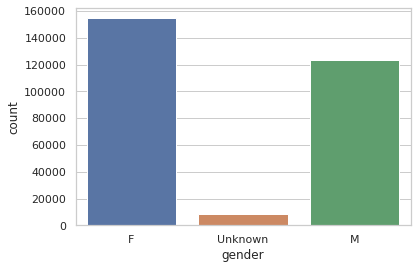

In [0]:
# conclusion : We have more number of female subscriber than male
import seaborn as sns 
display(sns.barplot(x='gender',y='count',data=gender_df))

In [0]:
# Location Analysis 
main_df.select("location").head(3)
# location column is combination of two field , State code & Town Area seprated by comma

Out[21]: [Row(location='Price, UT'),
 Row(location='Price, UT'),
 Row(location='Price, UT')]

In [0]:
main_df.select(["location","gender"]).head(3)

Out[22]: [Row(location='Chicago-Naperville-Elgin, IL-IN-WI', gender='M'),
 Row(location='Chicago-Naperville-Elgin, IL-IN-WI', gender='M'),
 Row(location='Chicago-Naperville-Elgin, IL-IN-WI', gender='M')]

In [0]:
# create two seprate column from location 
# user define function to split 
from pyspark.sql.functions import split
split_location = split(main_df['location'], ',')
main_df = main_df.withColumn('Area', split_location.getItem(0))
main_df = main_df.withColumn('state_code', split_location.getItem(1))
main_df.columns

Out[23]: ['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'Area',
 'state_code']

In [0]:
main_df.select("state_code").drop_duplicates().collect()

Out[27]: [Row(state_code=' NE-IA'),
 Row(state_code=' PA-NJ'),
 Row(state_code=' WA'),
 Row(state_code=' DC-VA-MD-WV'),
 Row(state_code=' AL'),
 Row(state_code=' MI'),
 Row(state_code=' MN-WI'),
 Row(state_code=' IL-IN-WI'),
 Row(state_code=None),
 Row(state_code=' MD-WV'),
 Row(state_code=' NH'),
 Row(state_code=' AK'),
 Row(state_code=' AR'),
 Row(state_code=' AZ'),
 Row(state_code=' MA-NH'),
 Row(state_code=' WV'),
 Row(state_code=' TN-MS-AR'),
 Row(state_code=' MO-IL'),
 Row(state_code=' TN'),
 Row(state_code=' NY'),
 Row(state_code=' MD'),
 Row(state_code=' OH'),
 Row(state_code=' FL'),
 Row(state_code=' IL'),
 Row(state_code=' IL-MO'),
 Row(state_code=' LA'),
 Row(state_code=' CA'),
 Row(state_code=' NY-NJ-PA'),
 Row(state_code=' UT'),
 Row(state_code=' TX'),
 Row(state_code=' SC'),
 Row(state_code=' MO-KS'),
 Row(state_code=' OR-WA'),
 Row(state_code=' UT-ID'),
 Row(state_code=' OK'),
 Row(state_code=' NV'),
 Row(state_code=' IA'),
 Row(state_code=' VA-NC'),
 Row(state_code=' RI-MA'),
 Row(state_code=' PA'),
 Row(state_code=' OR'),
 Row(state_code=' GA-AL'),
 Row(state_code=' KY-IN'),
 Row(state_code=' CT'),
 Row(state_code=' TN-VA'),
 Row(state_code=' OH-KY-IN'),
 Row(state_code=' SC-NC'),
 Row(state_code=' NJ'),
 Row(state_code=' GA'),
 Row(state_code=' MS'),
 Row(state_code=' MT'),
 Row(state_code=' CO'),
 Row(state_code=' PA-NJ-DE-MD'),
 Row(state_code=' VA'),
 Row(state_code=' NC-SC'),
 Row(state_code=' WI'),
 Row(state_code=' KY'),
 Row(state_code=' IN'),
 Row(state_code=' NC')]

In [0]:
# check all state codes
main_df.select("state_code").drop_duplicates().collect()
# when its on border they concatenate all the state code but they all belog to same Region

first_statecode = split(main_df['state_code'], '-')
main_df = main_df.withColumn("first_state_code",first_statecode.getItem(0))

In [0]:
# there is a first space char in the first_state_code field 
from pyspark.sql.functions import udf
remove_space = udf(lambda x: x.strip())
main_df.withColumn("first_state_code",remove_space(main_df.first_state_code))

Out[31]: DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, Area: string, state_code: string, first_state_code: string]

In [0]:
# remove blank space from column first_state_code
from pyspark.sql.functions import trim,col
main_df = main_df.withColumn("first_state_code",trim(col("first_state_code")))

In [0]:
# We have to combine region Data set to identify which region is our bastion 
# read region Data set
region = spark.table("region_csv")
region = region.withColumnRenamed("State Code","state_code")

# join two dataframe
combined_df = main_df.join(region,main_df.first_state_code == region.state_code)

In [0]:
print(combined_df.head())

Row(artist='Scatman John', auth='Logged In', firstName='Ryleigh', gender='F', itemInSession=195, lastName='Rogers', length=212.1922, level='free', location='Pontiac, IL', method='PUT', page='NextSong', registration=1536303841000, sessionId=106, song='Scatman (Ski-Ba-Bop-Ba-Dop-Bop)', status=200, ts=1538896058000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='107', Area='Pontiac', state_code=' IL', first_state_code='IL', State='Illinois', state_code='IL', Region='Midwest', Division='East North Central')

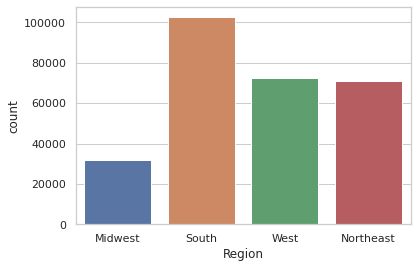

In [0]:
# to find bastion
region_count_pd = combined_df.select("Region").groupby("Region").count().toPandas()
display(sns.barplot(x='Region',y='count',data=region_count_pd))

In [0]:
main_df.groupby('artist').count().sort('count',ascending=False).head(5)

Out[40]: [Row(artist=None, count=58392),
 Row(artist='Kings Of Leon', count=1841),
 Row(artist='Coldplay', count=1813),
 Row(artist='Florence + The Machine', count=1236),
 Row(artist='Dwight Yoakam', count=1135)]

In [0]:
# top 5 artist
from pyspark.sql.functions import col, asc
main_df.filter(col("artist").isNotNull()).groupby('artist').count().sort('count',ascending=False).head(5)

Out[41]: [Row(artist='Kings Of Leon', count=1841),
 Row(artist='Coldplay', count=1813),
 Row(artist='Florence + The Machine', count=1236),
 Row(artist='Dwight Yoakam', count=1135),
 Row(artist='BjÃ\x83Â¶rk', count=1133)]

In [0]:
# top 5 songs 
main_df.filter(col("song").isNotNull()).groupby('song','artist').count().sort('count',ascending=False).head(5)

Out[42]: [Row(song="You're The One", artist='Dwight Yoakam', count=1122),
 Row(song='Undo', artist='BjÃ\x83Â¶rk', count=1026),
 Row(song='Revelry', artist='Kings Of Leon', count=854),
 Row(song='Sehr kosmisch', artist='Harmonia', count=728),
 Row(song='Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)', artist='Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner', count=641)]

In [0]:
# Is choice of Song depends on gender
print(main_df.filter((col("song").isNotNull()) & (col("gender") == 'M')).groupby('song','artist').count().sort('count',ascending=False).head(5))
print(main_df.filter((col("song").isNotNull()) & (col("gender") == 'F')).groupby('song','artist').count().sort('count',ascending=False).head(5))

[Row(song="You're The One", artist='Dwight Yoakam', count=515), Row(song='Undo', artist='BjÃ\x83Â¶rk', count=460), Row(song='Revelry', artist='Kings Of Leon', count=378), Row(song='Sehr kosmisch', artist='Harmonia', count=323), Row(song='Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)', artist='Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner', count=283)]
[Row(song="You're The One", artist='Dwight Yoakam', count=607), Row(song='Undo', artist='BjÃ\x83Â¶rk', count=566), Row(song='Revelry', artist='Kings Of Leon', count=476), Row(song='Sehr kosmisch', artist='Harmonia', count=405), Row(song='Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)', artist='Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner', count=358)]

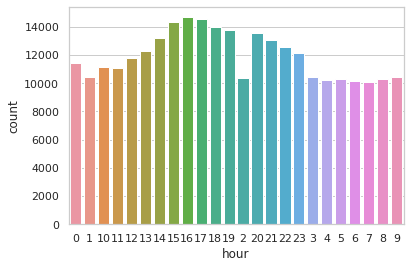

In [0]:
# Fav time of the day to listen songs
from pyspark.sql.functions import udf
import datetime
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).hour)
hour_pdf = main_df.withColumn("hour",get_hour(main_df.ts)).select("hour").sort("hour").toPandas()
display(sns.countplot(x="hour",data=hour_pdf.sort_values(by=['hour'])))

In [0]:
# how many customers have downgraded the paid subscription
main_df.select("page").filter(col("page") == "Submit Downgrade").count()

Out[52]: 63

In [0]:
# distinct user base
main_df.select("userId").drop_duplicates().count()

Out[53]: 226

In [0]:
# how many users uses paid service 
main_df.filter(col("userId") != '').filter(col("level") == 'paid').select("userId").drop_duplicates().count()

Out[56]: 165

In [0]:
# check month wise trend for customers for upgrade and downgrade service 
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).month)
month_wise = main_df.withColumn("month",get_month(main_df.ts))

In [0]:
print(month_wise.filter(col("page") == "Submit Downgrade").groupby("month","page").count().collect())
print(month_wise.filter(col("page") == "Submit Upgrade").groupby("month","page").count().collect())

[Row(month='10', page='Submit Downgrade', count=38), Row(month='11', page='Submit Downgrade', count=25)]
[Row(month='10', page='Submit Upgrade', count=111), Row(month='11', page='Submit Upgrade', count=48)]

In [0]:
main_df.filter(col("status") != 200).filter(col("page") == "Submit Downgrade"

Out[100]: DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, Area: string, state_code: string, first_state_code: string]

In [0]:
usr_id_list = main_df.filter(col("page") == "Submit Downgrade").select("userId").drop_duplicates().collect()

In [0]:
all_user = []
for row in usr_id_list:
  all_user.append(row[0])

In [0]:
main_df.filter(col("userId").isin(all_user)).select("status").filter(col("status") != 200).filter(col("page") == "Submit Downgrade").groupby("status").count().collect()

Out[113]: [Row(status=307, count=63)]

In [0]:
# conclusion: Almost all the users who has downgraded the service faced error status 307